# Gesture Recognition with CAPG DBA dataset

In this preliminary effort, we will try to perform hand gesture recognition from CAPG DBA dataset.

In this version:

- EMG data is normalized with the recorded MVC data
- EMG data (already preprocessed) **will not be processed** further.
- There is **no feature engineering**; raw EMG data will be used.
- **1D CNN** with simple architecture will be used.
- **Training data:** 5 trials per subject per gesture
- **Test data:** 5 trials per subject per gesture

**NOTE** This code has been tested with:
```
    numpy version:        1.23.5
    scipy version:        1.9.3
    sklearn version:      1.2.0
    seaborn version:      0.12.1
    pandas version:       1.5.2
    torch version:        1.12.1+cu113
    matplotlib version:   3.6.2
    CUDA version:         11.2
    cuDNN version:        8.1.0
```

## 1- Preliminaries

### Imports

In [20]:
import sys, os
direc = os.getcwd()
print("Current Working Directory is: ", direc)
KUACC = False
if "scratch" in direc: # We are using the cluster
    KUACC = True
    homedir = os.path.expanduser("~")
    os.chdir(os.path.join(homedir,"REPO/comp541-project/"))
    direc = os.getcwd()
    print("Current Working Directory is now: ", direc)
sys.path.append("../src/")
sys.path.append("../data/")
import torch
from datasets_torch import *
from models_torch import *
from utils_torch import *
from datetime import datetime
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import statistics
import json
from IPython.display import display

# Print versions
print("numpy version:       ", np.__version__)
print("scipy version:       ", sp.__version__)
print("sklearn version:     ", sklearn.__version__)
print("seaborn version:     ", sns.__version__)
print("pandas version:      ", pd.__version__)
print("torch version:       ", torch.__version__)
print("matplotlib version:  ", matplotlib.__version__)


# Checking to see if CUDA is available for us
print("Checking to see if PyTorch recognizes GPU...")
print(torch.cuda.is_available())

# Whether to use latex rendering in plots throughout the notebook
USE_TEX = False
FONT_SIZE = 12

# Setting matplotlib plotting variables
if USE_TEX:
    plt.rcParams.update({
        "text.usetex": True,
        "font.size": FONT_SIZE,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })
else:
    plt.rcParams.update({
        "text.usetex": False,
        "font.size": FONT_SIZE,
        "font.family": "serif",
        "font.serif": ["Times New Roman"]
    })

# Do not plot figures inline (only useful for cluster)
# %matplotlib

Current Working Directory is:  d:\ACADEMICS\2022_Fall\comp541-441\comp541-project\prelim
numpy version:        1.23.5
scipy version:        1.9.3
sklearn version:      1.2.0
seaborn version:      0.12.1
pandas version:       1.5.2
torch version:        1.12.1+cu113
matplotlib version:   3.6.2
Checking to see if PyTorch recognizes GPU...
True


## 2- Hyperparameters and Settings

### General settings of the study

In [2]:
study = {
    'code':'capg_dba_v001',
    'package':'torch',
    'dataset':'capg',
    'subdataset':'dba'
}

In [3]:
hparams = {
    "model_name": autoname("capg_dba_v001"),
    # General hyperparameters
    "in_features": 128,
    "out_features": 1,
    # Sequence hyperparameters
    "in_seq_len_sec": 0.1,
    "out_seq_len_sec": 0,
    "data_sampling_rate_Hz": 1000.0,
    "data_downsampling": 5,
    "sequence_downsampling": 1,
    "in_seq_len": 0,
    "out_seq_len": 0,
    "validation_data": [0.05,'trainset']
}

## 3- Data Processing

### Load and concatenate data

In [4]:
data_dir = "../data/CAPG/parquet"
def load_single_capg_dataset(data_dir, db_str:str="dba"):
    data_lst = []
    for i,file in enumerate(os.listdir(data_dir)):
        if file.endswith(".parquet") and db_str in file:
            print("Loading file: ", file)
            data_lst.append(pd.read_parquet(os.path.join(data_dir, file)))
    data = pd.concat(data_lst, axis=0, ignore_index=True)
    return data
dba_tot = load_single_capg_dataset(data_dir, db_str="dba")
dba_mvc = dba_tot.loc[dba_tot["gesture"].isin([100, 101])]
dba = dba_tot.loc[~dba_tot["gesture"].isin([100, 101])]
print("dba_tot shape: ", dba_tot.shape)
print("dba_mvc shape: ", dba_mvc.shape)
print("dba shape: ", dba.shape)
print("columns: ")
print(dba_tot.columns)

Loading file:  dba_subj_1.parquet
Loading file:  dba_subj_10.parquet
Loading file:  dba_subj_11.parquet
Loading file:  dba_subj_12.parquet
Loading file:  dba_subj_13.parquet
Loading file:  dba_subj_14.parquet
Loading file:  dba_subj_15.parquet
Loading file:  dba_subj_16.parquet
Loading file:  dba_subj_17.parquet
Loading file:  dba_subj_18.parquet
Loading file:  dba_subj_2.parquet
Loading file:  dba_subj_3.parquet
Loading file:  dba_subj_4.parquet
Loading file:  dba_subj_5.parquet
Loading file:  dba_subj_6.parquet
Loading file:  dba_subj_7.parquet
Loading file:  dba_subj_8.parquet
Loading file:  dba_subj_9.parquet
dba_tot shape:  (1476000, 131)
dba_mvc shape:  (36000, 131)
dba shape:  (1440000, 131)
columns: 
Index(['subject', 'gesture', 'trial', 'b_1_c_1', 'b_1_c_2', 'b_1_c_3',
       'b_1_c_4', 'b_1_c_5', 'b_1_c_6', 'b_1_c_7',
       ...
       'b_8_c_7', 'b_8_c_8', 'b_8_c_9', 'b_8_c_10', 'b_8_c_11', 'b_8_c_12',
       'b_8_c_13', 'b_8_c_14', 'b_8_c_15', 'b_8_c_16'],
      dtype='obje

### Normalize EMG Data

Here the recorded MVC values will be used for normalizaing EMG data

In [5]:
max_mvc = dba_mvc.iloc[:,3:].max(axis=0)
del dba_mvc
# print("max_mvc for 5 first channels: ")
# print(max_mvc[:5])
# print("shape of max_mvc: ", max_mvc.shape)
# print("max of dba before normalization: (first five)")
# print(dba.iloc[:,3:].max(axis=0)[:5])
dba.iloc[:,3:] = dba.iloc[:,3:].div(max_mvc, axis=1)
# print("max of dba_norm after normalization: ")
# print(dba_norm.iloc[:,3:].max(axis=0)[:5])

C:\Users\pouya\AppData\Local\Temp\ipykernel_5300\1353078018.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dba.iloc[:,3:] = dba.iloc[:,3:].div(max_mvc, axis=1)


### Generate tabulated data (and update hyperparameters accordingly)

In [6]:
input_cols = list(dba.iloc[:,3:].columns)
data_processed = generate_cell_array(
    dba, hparams,
    subjects_column="subject", conditions_column="gesture", trials_column="trial",
    input_cols=input_cols, output_cols=["gesture"], specific_conditions=None,
    input_preprocessor=None,
    output_preprocessor=None,
    subjects_for_testing=None, 
    trials_for_testing=[5,6,7,8,9,10],
    input_scaling=False, output_scaling=False, input_forward_facing=True, output_forward_facing=True, 
    data_squeezed=False,
    input_towards_future=False, output_towards_future=False, 
    output_include_current_timestep=True,
    use_filtered_data=False, #lpcutoff=CUTOFF, lporder=FILT_ORDER, lpsamplfreq=SAMPL_FREQ,
    return_data_arrays_orig=False,
    return_data_arrays_processed=False,
    return_train_val_test_arrays=False,
    return_train_val_test_data=True,
    verbosity=1
)

# Get rid of things we won't need anymore
del dba, dba_tot

# Correct output feature count (this is buggy behavior and should be fixed)
hparams['out_features'] = 8

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    []
conditions used for testing:  []
trials used for testing:      [6, 7, 8, 9, 10]


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   trainset
Validation data portion:  0.05
shape of x_test:  (144000, 32, 128)
shape of y_test:  (144000, 1)
x_train:  (136800, 32, 128)
y_train:  (136800, 1)
x_val:  (7200, 32, 128)
y_val:  (7200, 1)
x_test:  (144000, 32, 128)
y_test:  (144000, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  4719806991
Done.



In [7]:
# Inputs MUST have shape (batch_size, num_channels, seq_length) for 1D CNN (opposite of RNN)
x_train = data_processed["x_train"].transpose(0,2,1)
x_val = data_processed["x_val"].transpose(0,2,1)
x_test = data_processed["x_test"].transpose(0,2,1)
# Outputs MUST be zero-indexed class labels
y_train = data_processed["y_train"] - 1
y_val = data_processed["y_val"] - 1
y_test = data_processed["y_test"] - 1
del data_processed
print("x_train shape: ", x_train.shape)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (136800, 128, 32)
x_val shape:  (7200, 128, 32)
x_test shape:  (144000, 128, 32)
y_train shape:  (136800, 1)
y_val shape:  (7200, 1)
y_test shape:  (144000, 1)


In [8]:
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [9]:
train_set = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).long())
val_set = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).long())
test_set = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())

## 3- Training

In [10]:
hparams.update({
    # Convolution hyperparameters
    "num_conv_blocks": 2,
    "conv_channels": [32,64],
    "conv_kernel_size": 3,
    "conv_padding": "valid",
    "conv_activation": "relu",
    "conv_activation_params": None,
    "conv_batchnorm": "before",
    "conv_batchnorm_params": None,
    "conv_stride": 1,
    "conv_dropout": 0.1,
    "pool_padding": 0,
    "pool_kernel_size": 2,
    "pool_stride": 1,
    "min_image_size": 4,
    # Dense hyperparameters
    "dense_width": [64,32],
    "dense_depth": 2,
    "dense_dropout": 0.1,
    "dense_activation": "relu",
    "dense_activation_params": None,
    "output_activation": None,
    "output_activation_params": None,
    "dense_batchnorm": "before",
    "dense_batchnorm_params": None,
    # Training hyperparameters
    "l2_reg": None,
    "batch_size": 256,
    "epochs": 40,
    "validation_tolerance_epochs": 5,
    "learning_rate": 0.01,
    "learning_rate_decay_gamma": 0.85,
    "loss_function": "crossentropy",
    "optimizer": "adam",
    "optimizer_params": None
})

study['hparams'] = hparams

In [11]:
model = Image2Dense1D(hparams)
print(model)

Image2Dense1D(
  (net): Sequential(
    (0): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=valid)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout1d(p=0.1, inplace=False)
    (5): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=valid)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout1d(p=0.1, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1664, out_features=64, bias=True)
    (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Dropout(p=0.1, inplace=False)
    (15): Linear(in_features=64, out_features=32, bias=True)
    (16): BatchNorm1d(32, eps=1e-05, momentum=0.1

In [12]:
history = model.train_model([train_set, val_set], verbose=2, script_before_save=False, saveto=None)

Total number of data points:      144000
Number of training data points:   136800
Number of validation data points: 7200
Number of training batches:    535
Number of validation batches:  29
Batch size:                    256
Shape of training input from the dataloader:   torch.Size([256, 128, 32])
Shape of training output from the dataloader:  torch.Size([256])
Shape of validation input from the dataloader:   torch.Size([256, 128, 32])
Shape of validation output from the dataloader:  torch.Size([256])
Selected device:  cuda:0
The learning rate has an exponential decay rate of 0.85000.
Classification problem detected. We will look at accuracies.
Shape of model outputs:      torch.Size([256, 8])
Shape of class predictions:  torch.Size([256])
Shape of targets:            torch.Size([256])
Shape of model outputs:      torch.Size([256, 8])
Shape of class predictions:  torch.Size([256])
Shape of targets:            torch.Size([256])
Loss: 1.1908 |Val Loss: 0.6711 |Acc: 0.5298 |Val Acc: 0.773

In [13]:
study['training_history'] = history
json.dump(study, open(make_path("../results/"+hparams["model_name"]+"/study.json"), "w"), indent=4)

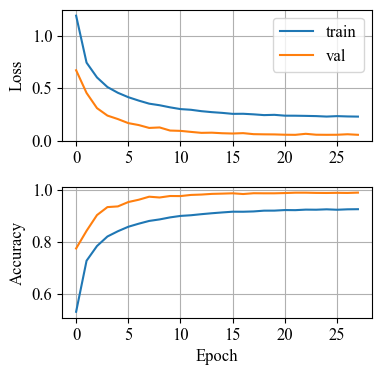

In [26]:
# Plot training history
plt.figure(figsize=(4,4), dpi=100)
plt.subplot(2,1,1)
plt.grid(True)
plt.plot(history["training_loss"], label="train")
plt.plot(history["validation_loss"], label="val")
# plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.subplot(2,1,2)
plt.grid(True)
plt.plot(history["training_metrics"], label="train")
plt.plot(history["validation_metrics"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# plt.legend(loc="lower right")
plt.subplots_adjust(
    hspace=0.35
)

plt.savefig(make_path("../results/"+hparams['model_name']+"/training_history.png"), dpi=300)